In [1]:
# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd
import xgboost as xgb

from scipy import stats

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['font.size'] = 10

# Modelado y Forecasting
# ==============================================================================
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from skforecast.utils import save_forecaster

from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import  KNeighborsRegressor
from sklearn import linear_model
from sklearn.model_selection import KFold, cross_val_score, train_test_split

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.ar_model import AutoReg

from skforecast.utils import load_forecaster

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from keras import optimizers,callbacks
from keras.models import Sequential, Model
from keras.layers import Conv1D, MaxPooling1D
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Flatten, Dropout, MultiHeadAttention, GlobalAveragePooling1D, Input

# Calculo de metricas
# ==============================================================================
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, median_absolute_error
from sklearn import metrics

# Configuración warnings
# ==============================================================================
import warnings
pd.options.mode.chained_assignment = None  # default='warn'
warnings.filterwarnings("ignore")
# warnings.filterwarnings('ignore')

In [2]:
def evaluacion_metrica(y_true, y_pred):
    
    def mean_absolute_percentage_error(y_true, y_pred): 
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print('Evaluation metric results:-')
    print(f'MSE: {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE: {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE: {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE: {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'R2: {metrics.r2_score(y_true, y_pred)}',end='\n\n')

In [3]:
# Carga de datos
# ==============================================================================
folder = "C:\\Users\\Martinejo\\Documents\\UMH\\INVESTIGACION\\MARGARITA_SALAS\\Sistema_Riego\\"
parametro = 'eto'
output=parametro
inputs_sen = [
          'fecha', 'eto','viento_med','precip','temp_med','hr_med','rad_med'
          ]
inputs_sat = [
          'date', 'ndvi_mean','ndwi_mean','ndmi_mean','gndvi_mean','evi_mean','evi2_mean','savi_mean'
          ]
usecols_sen = inputs_sen.copy()
usecols_sat = inputs_sat.copy()

datos_sen = pd.read_csv(folder + "agroclimatology_parcel_1" + ".csv",sep=',', usecols=usecols_sen)
datos_sat = pd.read_csv(folder + "teledeteccion_sentinel2_parcel_1" + ".csv",sep=',', usecols=usecols_sat)

datos_sen = datos_sen.drop_duplicates()
datos_sat = datos_sat.drop_duplicates()

#datos_sat["eto"] = 0
variable=[]
flag = 0

for k in range(len(datos_sat)):
    for q in range(len(datos_sen)):
        if(datos_sat.iloc[k].loc["date"] == datos_sen.iloc[q].loc["fecha"]):
            #print(datos_sen.iloc[q].loc["eto"])
            flag = 1
            variable.append(datos_sen.iloc[q].loc["eto"])
            #datos_sat.iloc[k].loc["eto"] = variable
            #print(variable)
    if (flag == 0):
        print(f"La fecha {datos_sat.iloc[k].loc['date']} no la tienen los sensores")
    flag = 0        
            
datos_sat["eto"] = variable

print(datos_sat)

           date  ndvi_mean  ndwi_mean  ndmi_mean  gndvi_mean  evi_mean  \
0    2022-01-10   0.352500  -0.477254  -0.045895    0.477254  0.197024   
1    2022-01-11   0.352500  -0.477254  -0.045895    0.477254  0.197024   
2    2022-01-15   0.373885  -0.481882  -0.052732    0.481882  0.227659   
3    2022-01-16   0.373885  -0.481882  -0.052732    0.481882  0.227659   
4    2022-01-20   0.376884  -0.461015  -0.017178    0.461015  0.218201   
..          ...        ...        ...        ...         ...       ...   
231  2023-08-13   0.364463  -0.435672   0.014997    0.435672  0.272539   
232  2023-08-14   0.364463  -0.435672   0.014997    0.435672  0.272539   
233  2023-08-18   0.385314  -0.467312   0.018224    0.467312  0.294597   
234  2023-08-19   0.385314  -0.467312   0.018224    0.467312  0.294597   
235  2023-08-23   0.367847  -0.444959   0.014626    0.444959  0.279567   

     evi2_mean  savi_mean   eto  
0     0.212094   0.220751  3.11  
1     0.212094   0.220751  0.58  
2     0.2

In [4]:
datos = datos_sen.copy()
datos["eto"].isna().sum()

0

In [5]:
while datos["eto"].isna().sum() > 0:
    datos = datos.fillna(value=datos.shift(1))
    datos["eto"].isna().sum()
datos["eto"].isna().sum()

0

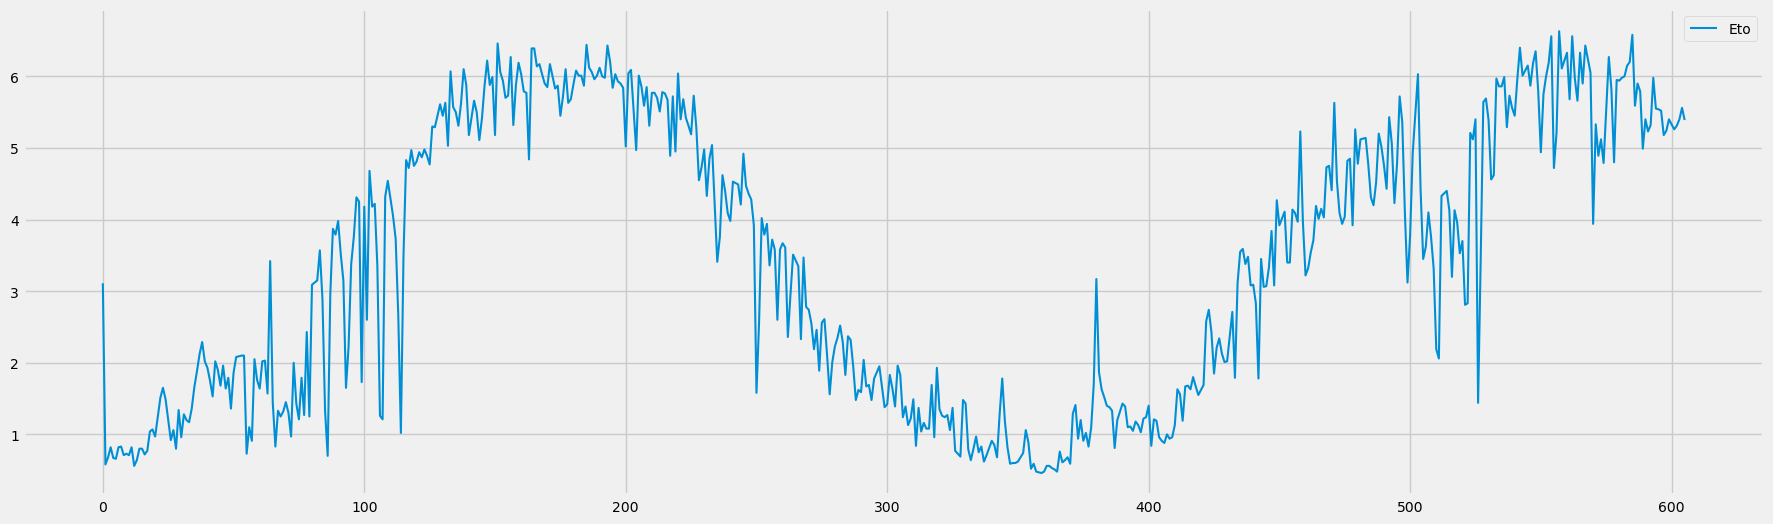

In [6]:
fig, ax = plt.subplots(figsize=(20, 6))
datos['eto'].plot(ax=ax, label='Eto')
ax.legend();

In [7]:
#datos = datos.drop(columns=["date"])
datos = datos.drop(columns=["fecha"])

In [9]:
inputs_sat = [
          'ndvi_mean','ndwi_mean','ndmi_mean','gndvi_mean','evi_mean','evi2_mean','savi_mean'
          ]

inputs_sen = [
          'viento_med','precip','temp_med','hr_med','rad_med'
          ]

entreno = 20

datos_entreno = datos.iloc[:-entreno] # PARA TENER UNA COPIA DEL ORIGINAL Y MODIFICAR LA COPIA

#X_train = datos[inputs_sat].iloc[:-entreno]
X_train = datos[inputs_sen].iloc[:-entreno]
y_train = datos[output].iloc[:-entreno]
#X_test = datos[inputs_sat].iloc[-entreno:]
X_test = datos[inputs_sen].iloc[-entreno:]
y_test = datos[output].iloc[-entreno:]

In [13]:
X = np.array(X_train)
y = np.array(y_train)
X_test = np.array(X_test)

# Crear una RNN de 5 capas
model_RNN = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(4, return_sequences=True, input_shape=(5, 1)),  # Capa RNN 1
    tf.keras.layers.SimpleRNN(4, return_sequences=True),  # Capa RNN 2
    tf.keras.layers.SimpleRNN(4, return_sequences=True),  # Capa RNN 3
    tf.keras.layers.SimpleRNN(4, return_sequences=True),  # Capa RNN 4
    tf.keras.layers.SimpleRNN(4),  # Capa RNN 5
    tf.keras.layers.Dense(1)  # Capa de salida con una neurona
])

# Compilar el modelo
model_RNN.compile(optimizer='adam', loss='mean_squared_error')

# Entrenar la RNN
model_RNN.fit(X, y, epochs=1000, verbose=0)

# Realizar predicciones
predicted = model_RNN.predict(X_test)

# Imprimir las predicciones
print("Predicciones:")
print(predicted)

1/1 [==============================] - 0s 357ms/step
Predicciones:
[[4.471418 ]
 [4.524378 ]
 [4.651975 ]
 [4.6466637]
 [4.512943 ]
 [3.8701775]
 [2.7417018]
 [4.7267942]
 [4.677169 ]
 [4.5567474]
 [4.689058 ]
 [4.6856637]
 [4.6877556]
 [4.447931 ]
 [3.6906164]
 [4.0271716]
 [4.5155034]
 [4.59638  ]
 [4.6014853]
 [4.639202 ]]


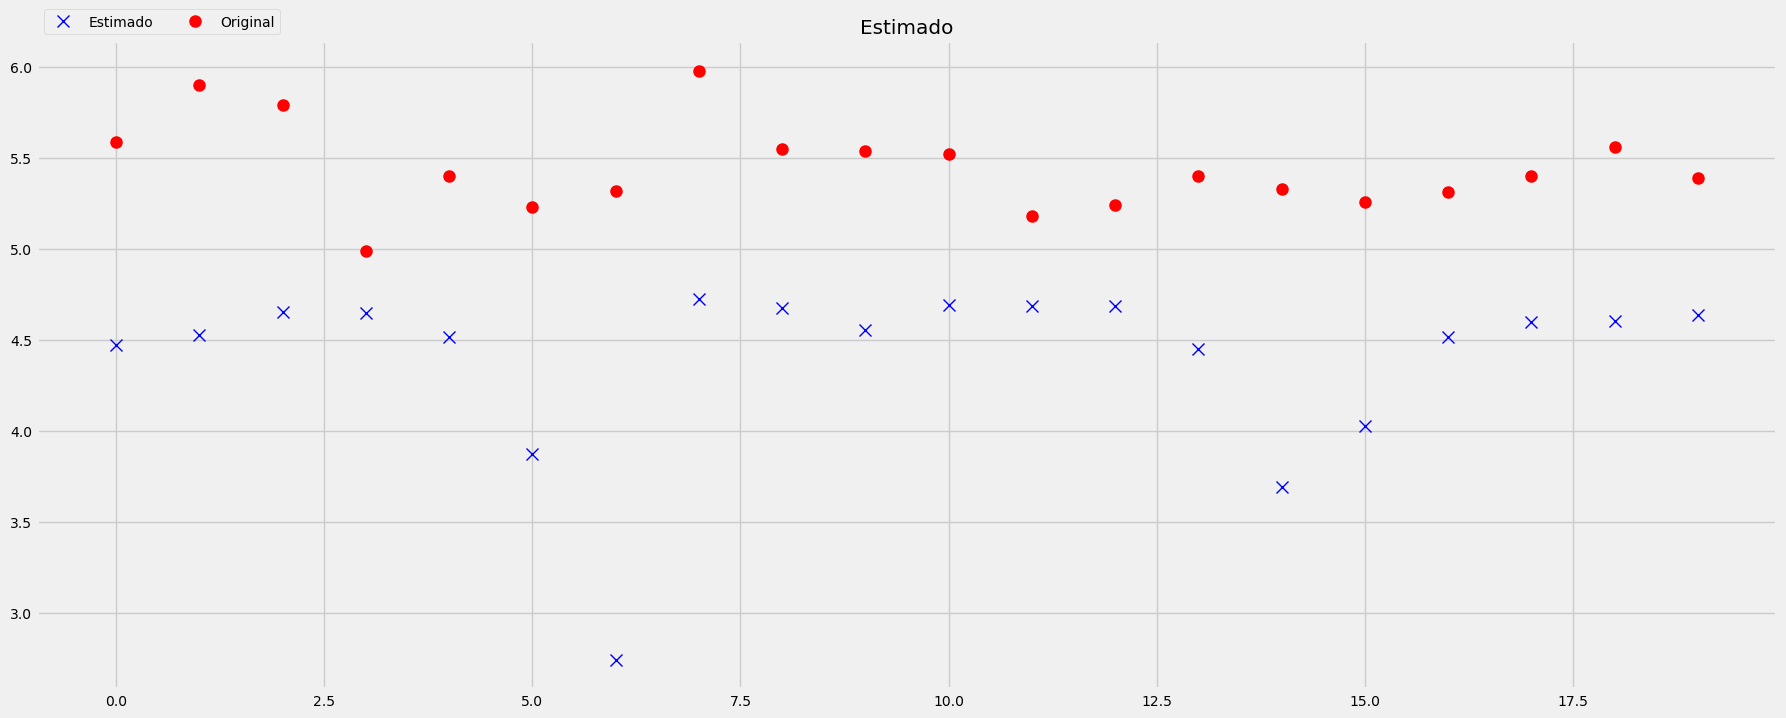

Evaluation metric results:-
MSE: 1.3126230617647985
MAE: 1.0459632935523986
RMSE: 1.1456976310374385
MAPE: 19.062403901472983
R2: -22.271808059087977



In [14]:
plt.figure(figsize=(20,8))

#plt.title('Y_predict')
l = plt.plot(predicted, 'o', color='blue', label="Estimado", marker='x')
plt.setp(l, markersize=8)

plt.title('Estimado')
q = plt.plot(y_test.values, 'o', color='red', label="Original")
plt.setp(q, markersize=8)
category_names = ['Estimado', 'Original']
legend = plt.legend(ncol=len(category_names), bbox_to_anchor=(0, 1),
              loc='lower left', fontsize='medium')
plt.show()

evaluacion_metrica(y_true = y_test.values,y_pred = predicted)